# Data Challenge Description

The file data.csv contains several columns of information for your analysis. The data are synthetic but were constructed to mimic data that we observe from real-world satellite images.

The car.count column shows the number of cars observed in a parking lot for a retail location like a WalMart or Home Depot. The weather and cloud.indicator columns tell something about whether the parking lot was visible each day.

We would like you to do some exploration of the data, fit some simple models, and summarize what you find, with the goal of both describing the data included and being able to forecast future values. We have in mind this should take no more than a couple of hours.

We are interested to know what you find, but also how you go about finding it. What process? What methods? What intuitions did you use to guide your investigation? Why did you do "this" or "that."

*Please produce some output including plots and other results to explain what you find and how you did it. Don't worry too much about making the output and plots pretty -- well organized is good enough.

Please use any analysis tools and methods that you wish for this project as long as you can explain what each is doing and why you chose to use it. 


Some example questions to answer:

1) Summarize in a qualitative way what you see in the data when you first look it over. What does this suggest for your "plan of attack" for your analysis? What techniques might be appropriate and useful?

2) How would you characterize your findings quantitatively?

3) What additional analysis might be useful if you had a whole day to work on the problem?




Our team will review your work and get back to you. We may ask to schedule a follow-up call if we would like to further review your work with you on a video call.

# Table of Contents
[Feature Engineering](#cell1)

[Linear Regression](#cell2)

[Neural Networks](#cell3)

[Decision Tree Regression](#cell4)

In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from matplotlib import pyplot as plt
import numpy as np
import glob, re
import seaborn as sns
from datetime import datetime,date
np.random.seed(41)
import calendar
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from scipy.stats import linregress

# Load and process the data

In [2]:
%%bash
ls data/

data.csv


### Create date features

In [3]:
data = pd.read_csv('data/data.csv')
data['date'] = pd.to_datetime(data['date'])
data['month.of.year'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['wom'] = data['date'].dt.day.apply(lambda d: (d-1) // 7 + 1)
data['day'] = data['month.of.year'] = data['date'].dt.day
data['date'] = data['date'].dt.date
data['cloud.indicator_binary'] = data['cloud.indicator'].factorize()[0]
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary
0,2010-01-01,Friday,101,0.1,clear,1,2010,1,1,0
1,2010-01-02,Saturday,34,0.2,cloudy,2,2010,1,2,1
2,2010-01-03,Sunday,113,0.4,clear,3,2010,1,3,0
3,2010-01-04,Monday,5,0.6,cloudy,4,2010,1,4,1
4,2010-01-05,Tuesday,124,0.1,clear,5,2010,1,5,0


### Do we have single data point for all dates?

In [4]:
data.shape

(2373, 10)

In [5]:
data['date'].describe()

count           2373
unique          2373
top       2011-08-30
freq               1
Name: date, dtype: object

YES!

### Do we have any missing values?

In [6]:
data.isnull().values.any()

False

In [7]:
data[data.isnull().T.any().T]

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary


NO!

### Is data sorted on dates?

In [8]:
print(data['date'].is_monotonic)
print(data.sample(frac=1)['date'].is_monotonic)
print(data['car.count'].is_monotonic)

True
False
False


<a id='cell1'></a>
## Extra feature engineering

### A feature for change from cloudy to clear or vice versa.

In [9]:
data['indicator_change'] = pd.Series(data['cloud.indicator'].factorize()[0]).diff()

In [10]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change
0,2010-01-01,Friday,101,0.1,clear,1,2010,1,1,0,NaN
1,2010-01-02,Saturday,34,0.2,cloudy,2,2010,1,2,1,1.0
2,2010-01-03,Sunday,113,0.4,clear,3,2010,1,3,0,-1.0
3,2010-01-04,Monday,5,0.6,cloudy,4,2010,1,4,1,1.0
4,2010-01-05,Tuesday,124,0.1,clear,5,2010,1,5,0,-1.0


### How many days do we have back to back with the same weather?

In [11]:
data['count_consecutive_cloud.indicator'] = data.groupby((data['cloud.indicator'] != data['cloud.indicator'].shift(1)).cumsum()).cumcount()+1
data.tail()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change,count_consecutive_cloud.indicator
2368,2016-06-26,Sunday,102,0.1,clear,26,2016,4,26,0,0.0,4
2369,2016-06-27,Monday,38,0.6,cloudy,27,2016,4,27,1,1.0,1
2370,2016-06-28,Tuesday,95,-1.6,clear,28,2016,4,28,0,-1.0,1
2371,2016-06-29,Wednesday,104,-0.1,clear,29,2016,5,29,0,0.0,2
2372,2016-06-30,Thursday,90,-0.3,cloudy,30,2016,5,30,1,1.0,1


### 100 day rolling mean

In [12]:
window = 100
data = data.merge(right = data[['date','car.count']].loc[data['cloud.indicator']=='cloudy'].rolling(window=window).mean().rename(columns={'car.count':'100_moving_ave_cloudy'}),
                  on='date',how='left')
data = data.merge(right = data[['date','car.count']].loc[data['cloud.indicator']=='clear'].rolling(window=window).mean().rename(columns={'car.count':'100_moving_ave'}),
                  on='date',how='left')
data = data.fillna(method='ffill')
print(data.head())
data.tail()

         date day.of.week  car.count  weather cloud.indicator  month.of.year  \
0  2010-01-01      Friday        101      0.1           clear              1   
1  2010-01-02    Saturday         34      0.2          cloudy              2   
2  2010-01-03      Sunday        113      0.4           clear              3   
3  2010-01-04      Monday          5      0.6          cloudy              4   
4  2010-01-05     Tuesday        124      0.1           clear              5   

   year  wom  day  cloud.indicator_binary  indicator_change  \
0  2010    1    1                       0               NaN   
1  2010    1    2                       1               1.0   
2  2010    1    3                       0              -1.0   
3  2010    1    4                       1               1.0   
4  2010    1    5                       0              -1.0   

   count_consecutive_cloud.indicator  100_moving_ave_cloudy  100_moving_ave  
0                                  1                    NaN   

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change,count_consecutive_cloud.indicator,100_moving_ave_cloudy,100_moving_ave
2368,2016-06-26,Sunday,102,0.1,clear,26,2016,4,26,0,0.0,4,54.29,114.61
2369,2016-06-27,Monday,38,0.6,cloudy,27,2016,4,27,1,1.0,1,54.08,114.61
2370,2016-06-28,Tuesday,95,-1.6,clear,28,2016,4,28,0,-1.0,1,54.08,114.16
2371,2016-06-29,Wednesday,104,-0.1,clear,29,2016,5,29,0,0.0,2,54.08,114.22
2372,2016-06-30,Thursday,90,-0.3,cloudy,30,2016,5,30,1,1.0,1,53.96,114.22


#### Remove NaN in the beginning:

In [13]:
first_valid_index = data['100_moving_ave'].first_valid_index()
first_valid_index_cloudy = data['100_moving_ave_cloudy'].first_valid_index()
print(first_valid_index,first_valid_index_cloudy)
data = data[data.index>max(first_valid_index,first_valid_index_cloudy)]
data.reset_index(drop=True,inplace=True)
print(data.head())
data.tail()

167 245
         date day.of.week  car.count  weather cloud.indicator  month.of.year  \
0  2010-09-04    Saturday        145     -2.0           clear              4   
1  2010-09-05      Sunday        146      0.6           clear              5   
2  2010-09-06      Monday        148      1.0           clear              6   
3  2010-09-07     Tuesday        148     -0.2           clear              7   
4  2010-09-08   Wednesday         18     -1.0          cloudy              8   

   year  wom  day  cloud.indicator_binary  indicator_change  \
0  2010    1    4                       0              -1.0   
1  2010    1    5                       0               0.0   
2  2010    1    6                       0               0.0   
3  2010    1    7                       0               0.0   
4  2010    2    8                       1               1.0   

   count_consecutive_cloud.indicator  100_moving_ave_cloudy  100_moving_ave  
0                                  1                  

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change,count_consecutive_cloud.indicator,100_moving_ave_cloudy,100_moving_ave
2122,2016-06-26,Sunday,102,0.1,clear,26,2016,4,26,0,0.0,4,54.29,114.61
2123,2016-06-27,Monday,38,0.6,cloudy,27,2016,4,27,1,1.0,1,54.08,114.61
2124,2016-06-28,Tuesday,95,-1.6,clear,28,2016,4,28,0,-1.0,1,54.08,114.16
2125,2016-06-29,Wednesday,104,-0.1,clear,29,2016,5,29,0,0.0,2,54.08,114.22
2126,2016-06-30,Thursday,90,-0.3,cloudy,30,2016,5,30,1,1.0,1,53.96,114.22


### Car.count_subtracted feature removes long-term trends

This could be a feature to gain further insights into really high or low values. They do not serve any purpose for a machine learning model because they are constructed using target value. Is there any regularity?

In [14]:
data['car.count_subtracted'] = data['car.count']-data['100_moving_ave']
data['car.count_subtracted_cloudy'] = data['car.count']-data['100_moving_ave_cloudy']
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change,count_consecutive_cloud.indicator,100_moving_ave_cloudy,100_moving_ave,car.count_subtracted,car.count_subtracted_cloudy
0,2010-09-04,Saturday,145,-2.0,clear,4,2010,1,4,0,-1.0,1,64.07,128.03,16.97,80.93
1,2010-09-05,Sunday,146,0.6,clear,5,2010,1,5,0,0.0,2,64.07,128.41,17.59,81.93
2,2010-09-06,Monday,148,1.0,clear,6,2010,1,6,0,0.0,3,64.07,128.90,19.10,83.93
3,2010-09-07,Tuesday,148,-0.2,clear,7,2010,1,7,0,0.0,4,64.07,129.33,18.67,83.93
4,2010-09-08,Wednesday,18,-1.0,cloudy,8,2010,2,8,1,1.0,1,63.91,129.33,-111.33,-45.91


### Car.substracted vs date

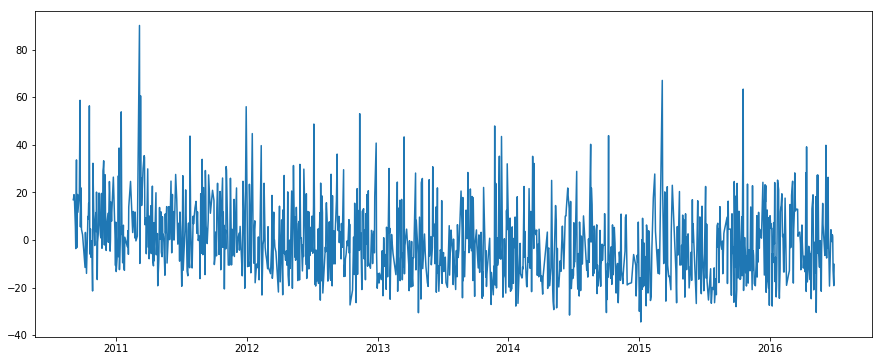

In [15]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear'),'date']
y = data.loc[(data['cloud.indicator']=='clear'),'car.count_subtracted']
plt.plot(x,y)

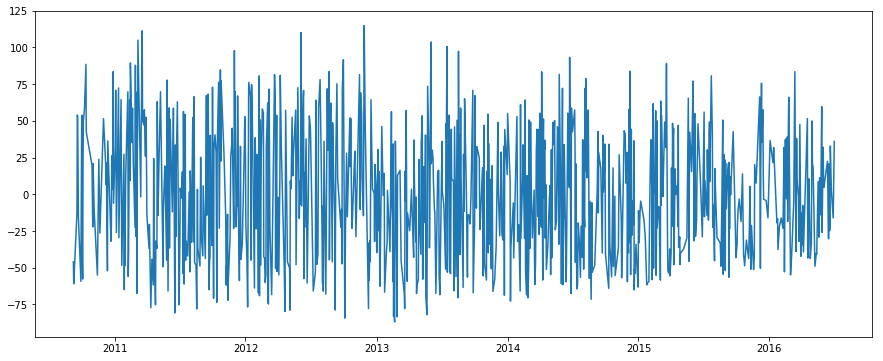

In [16]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='cloudy'),'date']
y = data.loc[(data['cloud.indicator']=='cloudy'),'car.count_subtracted_cloudy']
plt.plot(x,y)

## Distribution of car.count

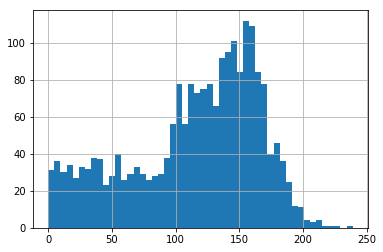

In [17]:
data['car.count'].hist(bins=50)

## Cloud indicator vs car count

### How many different kinds of cloud.indicators are there?
More fine grained cloud indicators could be useful.

In [18]:
data['cloud.indicator'].unique()

array(['clear', 'cloudy'], dtype=object)

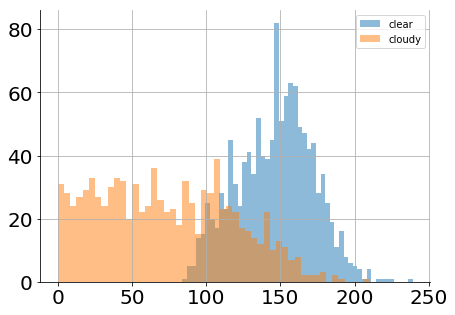

In [19]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[data['cloud.indicator']=='clear','car.count'].hist(bins=50,ax=ax,label='clear',alpha=0.5)
data.loc[data['cloud.indicator']=='cloudy','car.count'].hist(bins=50,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

Clearly the distribution of car counts are very different if we have a cloudy day.

## Does having a lot of back to back clear or cloudy days increase values?

In [20]:
x = data.loc[data['cloud.indicator']=='clear','count_consecutive_cloud.indicator']
y = data.loc[data['cloud.indicator']=='clear','car.count_subtracted']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

0.341854018817 -1.5765899993 0.0401811647877 0.162989532008 0.244891533672


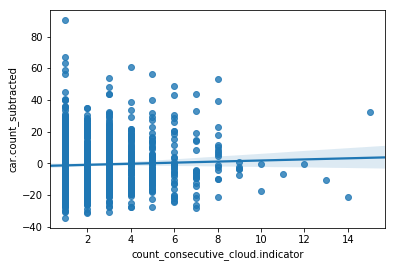

In [21]:
ax = sns.regplot(x='count_consecutive_cloud.indicator', y="car.count_subtracted", data=data[data['cloud.indicator']=='clear'])

In [22]:
x = data.loc[data['cloud.indicator']=='cloudy','count_consecutive_cloud.indicator']
y = data.loc[data['cloud.indicator']=='cloudy','car.count_subtracted_cloudy']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

0.819632244066 -2.15817497975 0.0267946646831 0.416927503518 1.00923757226


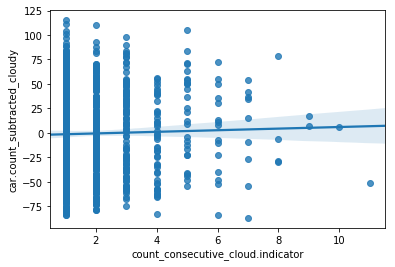

In [23]:
ax = sns.regplot(x='count_consecutive_cloud.indicator', y="car.count_subtracted_cloudy", data=data[data['cloud.indicator']=='cloudy'])

## Date features vs car_count

### Weekday vs car

(40, 100)

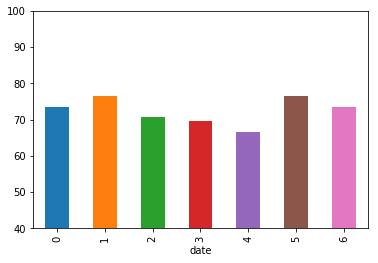

In [25]:
data[data['cloud.indicator']=='cloudy'].groupby(pd.to_datetime(data['date']).dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

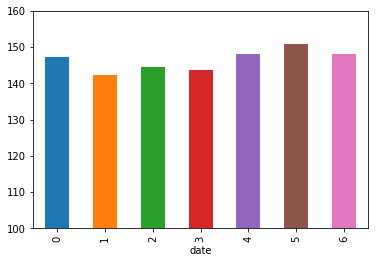

In [26]:
data[data['cloud.indicator']=='clear'].groupby(pd.to_datetime(data['date']).dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((100,160))

There doesn't seem to be a strong variation between weekdays. There is also an interaction between weekdays and car count.

#### Day vs car.count

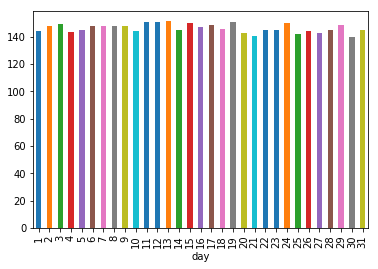

In [27]:
data[data['cloud.indicator']=='clear'].groupby('day')['car.count'].mean().plot.bar()

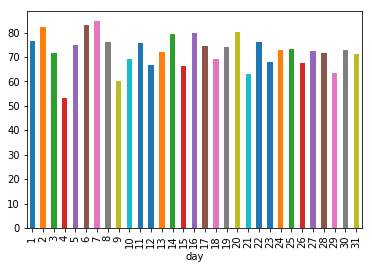

In [30]:
data[data['cloud.indicator']=='cloudy'].groupby('day')['car.count'].mean().plot.bar()

### Is the decrease we have on the 4th day of the month result of having too few samples for that date?

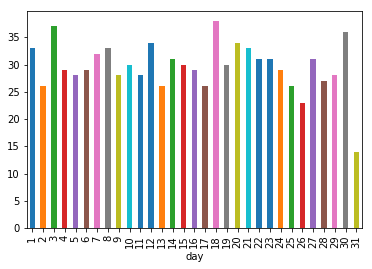

In [31]:
data[data['cloud.indicator']=='cloudy'].groupby('day')['car.count'].count().plot.bar()

### Month vs. car_count

(40, 100)

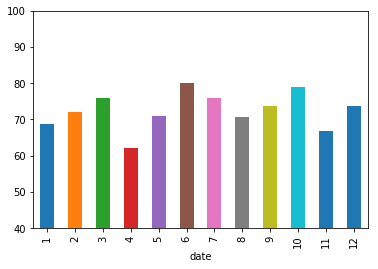

In [32]:
data[data['cloud.indicator']=='cloudy'].groupby(pd.to_datetime(data['date']).dt.month)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

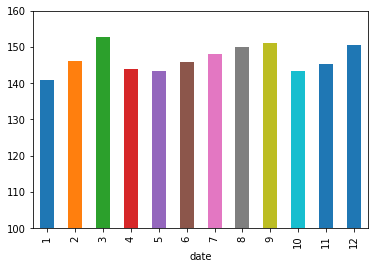

In [33]:
data[data['cloud.indicator']=='clear'].groupby(pd.to_datetime(data['date']).dt.month)['car.count'].mean().plot.bar()
plt.ylim((100,160))

Slightly bigger effect with months, interestingly interaction seems to be very small

### Weak of the month vs car.count

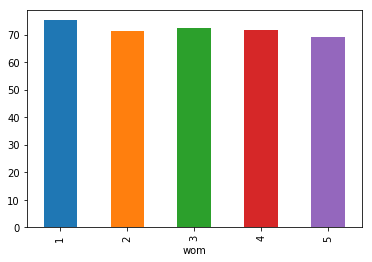

In [34]:
data[data['cloud.indicator']=='cloudy'].groupby('wom')['car.count'].mean().plot.bar()

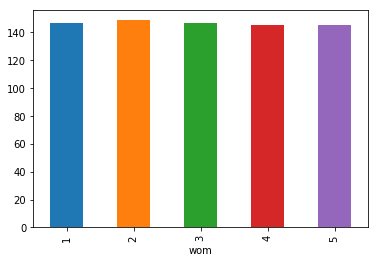

In [35]:
data[data['cloud.indicator']=='clear'].groupby('wom')['car.count'].mean().plot.bar()

### Year vs. car.count

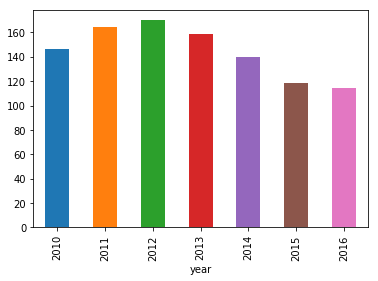

In [36]:
data[data['cloud.indicator']=='clear'].groupby('year')['car.count'].mean().plot.bar()
#plt.ylim((100,160))

Most likely there is recovery after financial crisis followed by retail apocalypse

### Cloud indicator vs month

Should we expect more cloudy days depending on the day of the month?

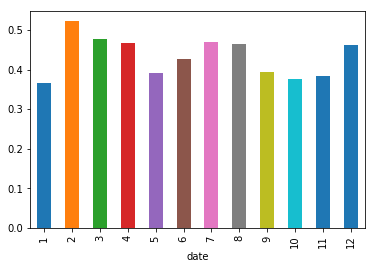

In [38]:
data.groupby(pd.to_datetime(data['date']).dt.month)['cloud.indicator_binary'].mean().plot.bar()

## Weather vs car_count

In [40]:
np.sort(data['weather'].unique())

array([-3.2, -3.1, -3. , -2.9, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1,
       -2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. ,
       -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,
        0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,
        1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,
        2.4,  2.5,  2.6,  2.7,  2.8,  3. ,  3.1,  3.2,  3.3,  4.3])

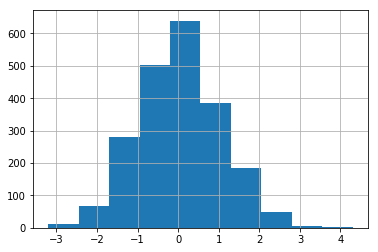

In [41]:
data['weather'].hist()

#### Looks like weather is a standard normal distribution

### Is there a relationship between car.count and weather?

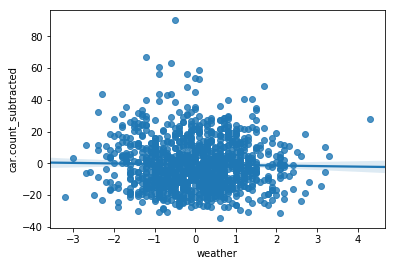

In [55]:
ax = sns.regplot(x="weather", y="car.count_subtracted", data=data[data['cloud.indicator']=='clear'])

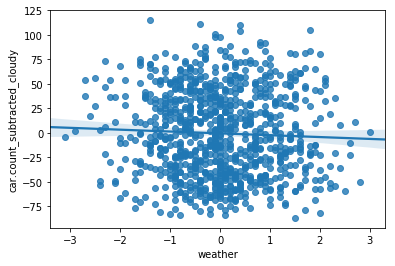

In [56]:
ax = sns.regplot(x="weather", y="car.count_subtracted_cloudy", data=data[(data['cloud.indicator']=='cloudy')])

In [57]:
x = data.loc[data['cloud.indicator']=='clear','weather']
y = data.loc[data['cloud.indicator']=='clear','car.count_subtracted']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

-0.334618984366 -0.741685628392 -0.0218011225514 0.449219005902 0.44205363366


In [58]:
x = data.loc[data['cloud.indicator']=='cloudy','weather']
y = data.loc[data['cloud.indicator']=='cloudy','car.count_subtracted_cloudy']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

-1.88397475207 -0.561673913043 -0.0438307413864 0.184084591598 1.41728552258


### Is there a difference in weather distribution in really high car.count values?

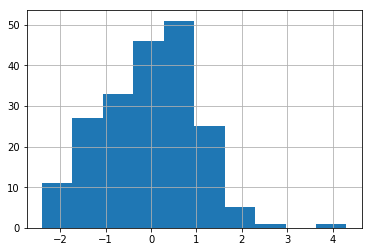

In [72]:
data[data['cloud.indicator']=='clear'].sort_values('car.count_subtracted',ascending=False)[:200]['weather'].hist()

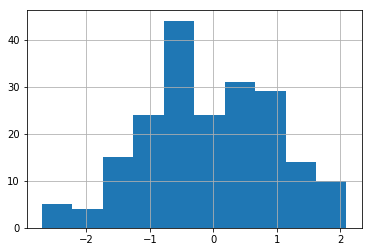

In [73]:
data[data['cloud.indicator']=='cloudy'].sort_values('car.count_subtracted',ascending=False)[:200]['weather'].hist()

There doesn't seem to be an significant relationship between weather and car count.

### Difference in weather in cloudy vs clear days

Normally we would expect cloudy days to be colder.

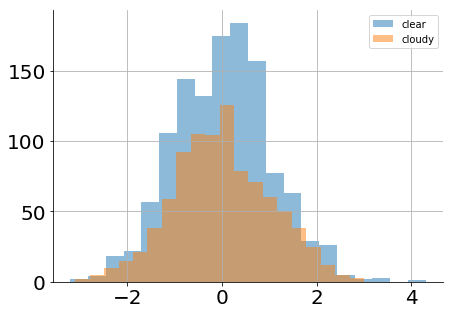

In [68]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='clear'),'weather'].hist(bins=20,ax=ax,label='clear',alpha=0.5)
data.loc[(data['cloud.indicator']=='cloudy'),'weather'].hist(bins=20,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

## Time vs car_count

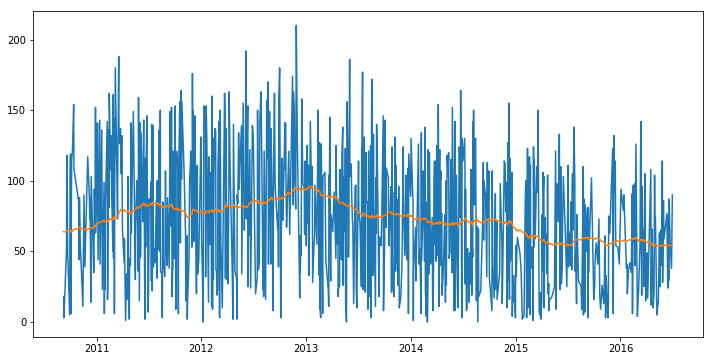

In [74]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='cloudy','date']
y = data.loc[data['cloud.indicator']=='cloudy','car.count']
plt.plot(x,y)
plt.plot(x,data.loc[data['cloud.indicator']=='cloudy','100_moving_ave_cloudy'])

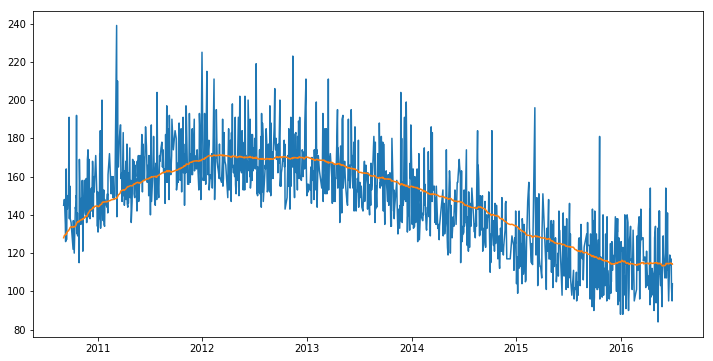

In [75]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='clear','date']
y = data.loc[data['cloud.indicator']=='clear','car.count']
plt.plot(x,y)
plt.plot(x,data.loc[data['cloud.indicator']=='clear','100_moving_ave'])

# Are there oscillations within years?

Do we need more moving averages?

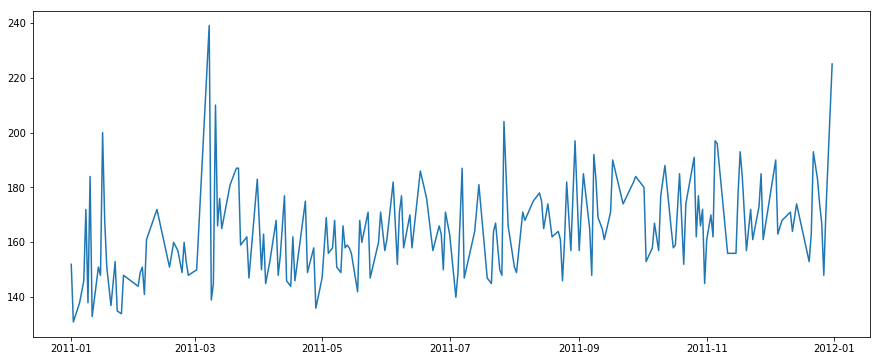

In [82]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2011),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2011),'car.count']
plt.plot(x,y)

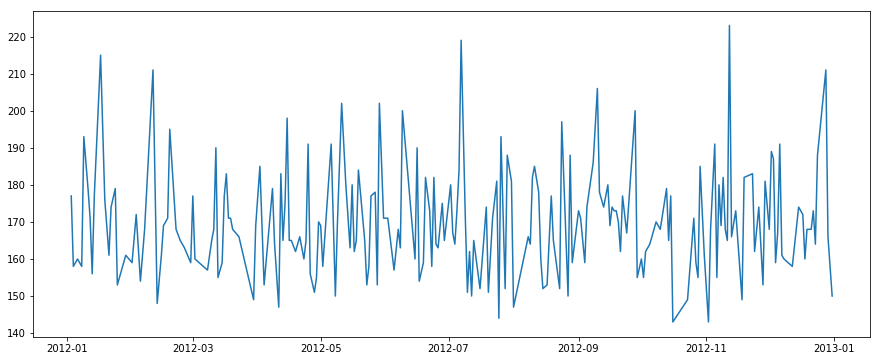

In [81]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'car.count']
plt.plot(x,y)

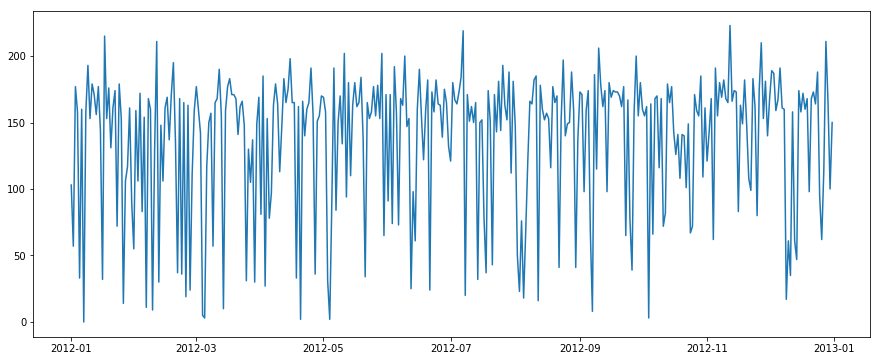

In [80]:
plt.figure(figsize=(15,6))
x = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'car.count']
plt.plot(x,y)

# Could indicator change be a reason for spikes?

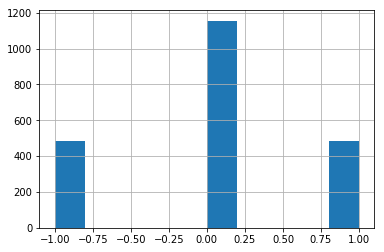

In [83]:
data['indicator_change'].hist()

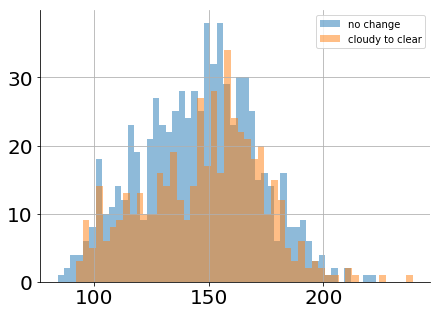

In [91]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='clear')&(data['indicator_change']==0),'car.count'].hist(bins=50,ax=ax,label='no change',alpha=0.5)
data.loc[(data['cloud.indicator']=='clear')&(data['indicator_change']==-1),'car.count'].hist(bins=50,ax=ax,label='cloudy to clear',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

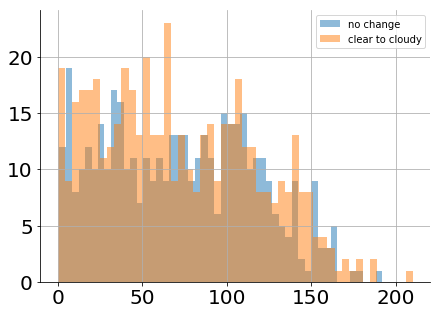

In [93]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='cloudy')&(data['indicator_change']==0),'car.count'].hist(bins=50,ax=ax,label='no change',alpha=0.5)
data.loc[(data['cloud.indicator']=='cloudy')&(data['indicator_change']==1),'car.count'].hist(bins=50,ax=ax,label='clear to cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

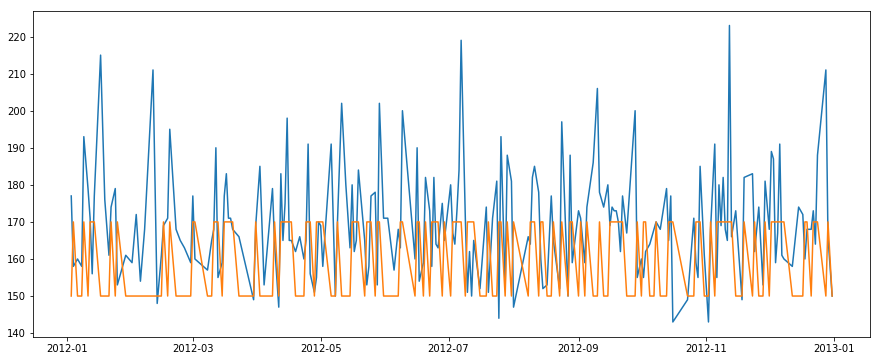

In [87]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'car.count']
z = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'indicator_change']
z = z*20+170
plt.plot(x,y)
plt.plot(x,z)

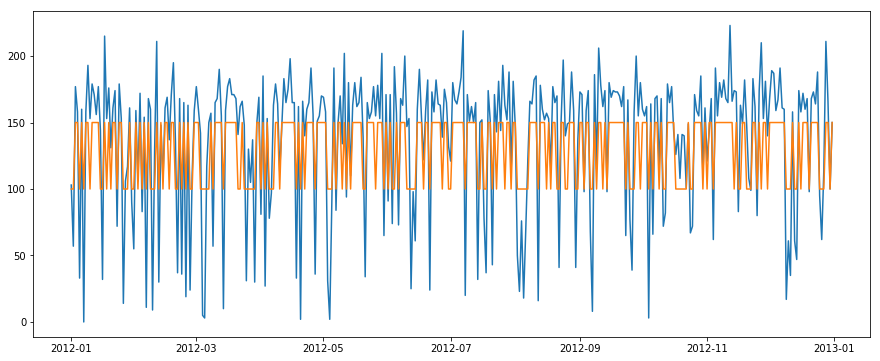

In [97]:
plt.figure(figsize=(15,6))
x = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'car.count']
z = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'cloud.indicator'].factorize()[0]
z = z*50+100
plt.plot(x,y)
plt.plot(x,z)


<a id='cell2'></a>
# Linear Regression

### Preprocessing steps for Linear Regression

In [106]:
X = pd.concat([pd.get_dummies(data[['day.of.week']]),
               pd.get_dummies(pd.to_datetime(data['date']).dt.month),
               pd.get_dummies(data['indicator_change'].astype(str)),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
              data[['car.count','date']],
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['weather'].values.reshape(-1, 1))[:,0],name='weather'),
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave'].values.reshape(-1, 1))[:,0],name='100_moving_ave'),
               pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave_cloudy'].values.reshape(-1, 1))[:,0],name='100_moving_ave'),
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['count_consecutive_cloud.indicator'].values.reshape(-1, 1))[:,0],name='count_consecutive_cloud.indicator')],
              axis=1)
print(X.columns.tolist())
X.head()

['day.of.week_Friday', 'day.of.week_Monday', 'day.of.week_Saturday', 'day.of.week_Sunday', 'day.of.week_Thursday', 'day.of.week_Tuesday', 'day.of.week_Wednesday', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, '-1.0', '0.0', '1.0', 'cloud.indicator', 'car.count', 'date', 'weather', '100_moving_ave', '100_moving_ave', 'count_consecutive_cloud.indicator']


/home/eminozkan/.conda/envs/challenge/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,day.of.week_Friday,day.of.week_Monday,day.of.week_Saturday,day.of.week_Sunday,day.of.week_Thursday,day.of.week_Tuesday,day.of.week_Wednesday,1,2,3,...,-1.0,0.0,1.0,cloud.indicator,car.count,date,weather,100_moving_ave,100_moving_ave,count_consecutive_cloud.indicator
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,145,2010-09-04,0.160000,0.254642,0.247478,0.000000
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,146,2010-09-05,0.506667,0.261176,0.247478,0.071429
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,148,2010-09-06,0.560000,0.269601,0.247478,0.142857
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,148,2010-09-07,0.400000,0.276994,0.247478,0.214286
4,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,18,2010-09-08,0.293333,0.276994,0.243725,0.000000


In [107]:
X.isnull().values.any()

False

In [108]:
X_train = X[X['date']<date(2015,1,1)]
X_valid = X[(date(2016,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

(1580, 29) (181, 29)


In [146]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True)

In [138]:
def print_metrics(y_true,y_pred):
    y_mean = np.full(y_true.shape,y_true.mean())
    print('R2',r2_score(y_true,y_pred)) # this is R2 value
    print('R2 for baseline',r2_score(y_true,y_mean)) # this is R2 value for baseline
    print('explained_variance_score',explained_variance_score(y_true,y_pred)) # this is R2 value
    print('explained_variance_score for the baseline model',explained_variance_score(y_true,y_mean)) # this is explained variance for the mean model
    print('mean_absolute_error',mean_absolute_error(y_true,y_pred)) # this is R2 value
    print('mean_absolute_error for the baseline model',mean_absolute_error(y_true,y_mean)) # this is R2 value
    

# Ridge regression

In [147]:
from sklearn.linear_model import Ridge

x = X_train.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
print('training data dimensions',x.shape)
y_true = X_train['car.count']
clf = Ridge(alpha=100.0, 
            fit_intercept=True, 
            normalize=False, 
            copy_X=True, 
            max_iter=None, 
            tol=0.001, solver='auto', random_state=None)
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

training data dimensions (1580, 379)
R2 0.618526430675
R2 for baseline 0.0
explained_variance_score 0.618526430675
explained_variance_score for the baseline model 0.0
mean_absolute_error 23.6649725984
mean_absolute_error for the baseline model 43.0679594616


In [148]:
x = X_valid.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

R2 0.354251871447
R2 for baseline 0.0
explained_variance_score 0.568549104623
explained_variance_score for the baseline model 0.0
mean_absolute_error 24.1597086023
mean_absolute_error for the baseline model 29.5763865572


### y_true vs y_pred

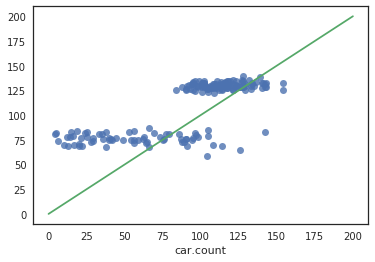

In [149]:
ax = sns.regplot(x=y_true, y=y_pred,fit_reg=False)
plt.plot([0,200],[0,200])

#### Plot below shows the coefficients without interactions (if there are interactions this plot cannot be plotted)

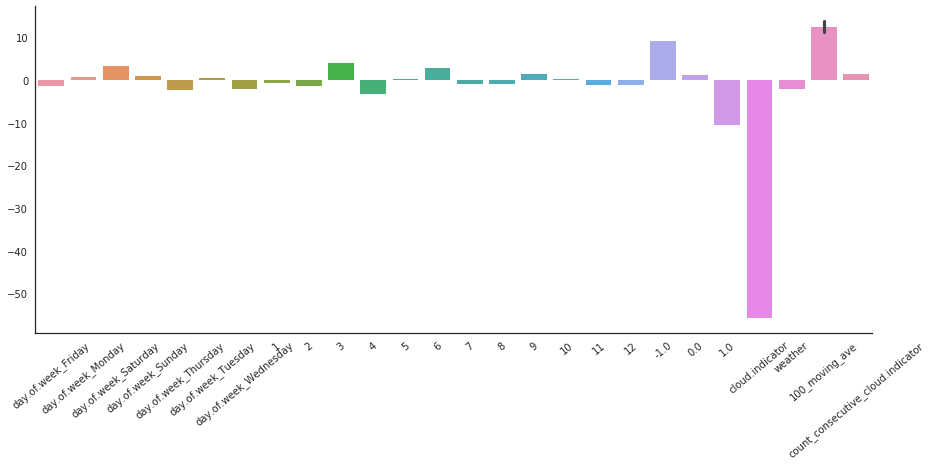

In [136]:
plt.figure(figsize=(15,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

# Lasso

In [158]:
from sklearn.linear_model import Lasso

x = X_train.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_train['car.count']
clf = Lasso(alpha=0.1, fit_intercept=True, 
            normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, 
            warm_start=False, positive=False, random_state=None, selection='cyclic')
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

R2 0.63177133164
R2 for baseline 0.0
explained_variance_score 0.63177133164
explained_variance_score for the baseline model 0.0
mean_absolute_error 23.3237769454
mean_absolute_error for the baseline model 43.0679594616


In [160]:
x = X_valid.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

R2 0.490362839939
R2 for baseline 0.0
explained_variance_score 0.545125868034
explained_variance_score for the baseline model 0.0
mean_absolute_error 21.5829282934
mean_absolute_error for the baseline model 29.5763865572


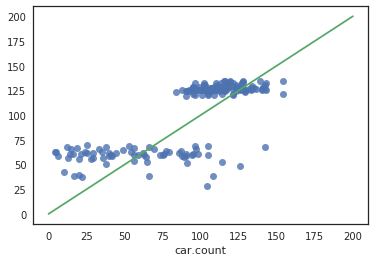

In [161]:
ax = sns.regplot(x=y_true, y=y_pred,fit_reg=False)
plt.plot([0,200],[0,200])

#### How many coefficients are selected?

In [170]:
np.nonzero(clf.coef_)[0].shape

(62,)

#### Plot below shows the coefficients without interactions (if there are interactions this plot cannot be plotted)

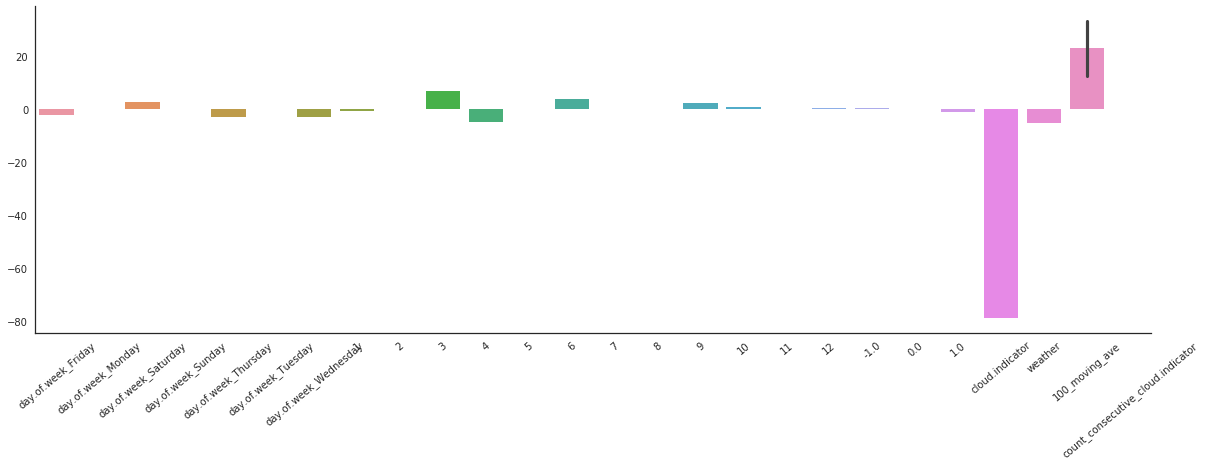

In [157]:
plt.figure(figsize=(20,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

# SVR

In [ ]:
from sklearn.svm import SVR

x = X_train.drop(['date','car.count'],axis=1)
y_true = X_train['car.count']
clf = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=100, 
          epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value



In [ ]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

In [ ]:
plt.figure(figsize=(20,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

<a id='cell3'></a>

# Neural Network

In [ ]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout, Flatten, Dense,BatchNormalization, GaussianNoise, Activation
from keras import optimizers



train_set = X_train.drop(['date','car.count'],axis=1)
train_labels = X_train['car.count']
valid_set = X_valid.drop(['date','car.count'],axis=1)
valid_labels = X_valid['car.count']


# Create the model
model = Sequential()
model.add(Dense(28, input_shape=x.shape[1:]))
model.add(Dense(14, activation='relu'))
model.add(Dense(1, name='three'))
model.summary()

rms_optimizer = optimizers.RMSprop(lr=0.1)
model.compile(loss='mean_squared_error', optimizer=rms_optimizer)

weight_file = 'weights_best.hdf5'

checkpointer = ModelCheckpoint(filepath=weight_file,
                               verbose=1, save_best_only=True)

model.fit(train_set, train_labels,
                 validation_data=(valid_set, valid_labels),
                 epochs=20, batch_size=1024,
                 callbacks=[checkpointer], verbose=2)

In [ ]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
model.load_weights(weight_file)
y_pred =  model.predict(valid_set)[:,0]
print('R2',r2_score(y_pred,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

x = X_train.drop(['date','car.count'],axis=1)
y_true = X_train['car.count']
clf = KNeighborsRegressor(n_neighbors=20, 
                          weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', 
                          metric_params=None, n_jobs=1)
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

In [ ]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print('R2',clf.score(x,y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

<a id='cell4'></a>

# Decision tree regression

In [ ]:
data.head()

## Preprocessing steps for decision tree regression

In [ ]:
X = pd.concat([pd.Series(data['month.of.year'].factorize()[0],name='month.of.year'),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
               pd.Series(data['day.of.week'].factorize()[0],name='day.of.week'),
              data[['car.count','date','weather','100_moving_ave','count_consecutive_cloud.indicator','indicator_change']]],axis=1)
X.head()

In [ ]:
X_train = X[X['date']<date(2015,1,1)]
X_valid = X[(date(2015,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

In [ ]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train.drop(['date','car.count'],axis=1),  X_train['car.count'])

lgb_eval = lgb.Dataset(X_valid.drop(['date','car.count'],axis=1),  X_valid['car.count'])

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mean_squared_error'},
    #'num_leaves': 8,
    'learning_rate': 0.1,
    'verbose': 50
}
print('Start training...')
# train
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                evals_result=evals_result,
                early_stopping_rounds=1)

In [ ]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = gbm.predict(x, num_iteration=gbm.best_iteration)
print('R2',r2_score(y_true,y_pred)) # this is R2 value
print('explained_variance_score',explained_variance_score(y_pred, y_true)) # this is R2 value
print('explained_variance_score',explained_variance_score(np.full(y_true.shape,y_true.mean()),y_true)) # this is explained variance for the mean model
print('mean_absolute_error',mean_absolute_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error',mean_absolute_percentage_error(y_pred, y_true)) # this is R2 value
print('mean_absolute_percentage_error for the mean model',mean_absolute_percentage_error(np.full(y_true.shape,y_true.mean()), y_true)) # this is R2 value

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
lgb.plot_importance(gbm,ax=ax,importance_type='gain')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

# Conclusion:

I started by making sure that there are no missing values and the data is sorted on date. This is pretty important for time-series data. After EDA, I found that having a cloudy day impairs having an accurate estimate of car counts. There are weak variations in car counts depending on the day of the week or month of the year. I also did not find a correlation between weather and car counts. There was however strong long term trends when looking at years seperately, with the highest amount of cars present in 2012. I also constructed models in order to predict feature values of car counts. My initial models were really bad. However by including a 100 day moving median, I was able to capture long-term trends, and this significantly improved my models. I was able to obtain R2 value of around 0.4 in the validation data, which is not great, but it shows that we have a significant imporevement compared to a mean model. Looking for coefficients of both linear models and non-linear models we can see that the most important coefficient is cloud_indicator, and this makes sense. If it is cloudy there are less cars. The second most important coefficient is 100-day moving average, and the other coefficients have a very small role in terms of being able to predict the number of car counts.

Given more time I would:

1) Tune models; for example find the best regularization coefficients.
2) Try to work on identifying outliers by doing someting like bollinger bands or RSI (this was a question in my phone talk with Steve).
3) Include week of the month and see if this imporves the model (I doubt it)
4) Engineer another feature such as how many days back to back it was cloudy and clear etc. It could be that having a lot of cloudy or clear days together may change people's mood and they may visit a store more or less.